In [2]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.equations.gross_pitaevskii import GPE2DTSControl
from pde_opt.numerics.solvers import StrangSplitting
from pde_opt.numerics.utils.initialization_utils import initialize_Psi, add_vortex_to_wavefunction
from pde_opt import PDEModel

In [13]:
def density(psi):
    return jnp.abs(psi)**2

atoms = 5e5
hbar = 1.05e-34 #J*s
omega = 2*jnp.pi*10 #1/s
omega_z = jnp.sqrt(8)*omega
epsilon = 0.0
mass = 3.8175406e-26 #kg (atomic mass of sodium-23)
a0 = 5.29177210903e-11
a_s = 100*a0
N = 128

x_s = jnp.sqrt(hbar/(mass*omega))
t_s = 1/omega

# Length of the x and y axes in meters
Lx = 150e-6 #meters
Ly = 150e-6 #meters

# Get dimensionless variables
Lx_ = Lx/x_s
Ly_ = Ly/x_s

# Get k
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass*omega_z)/(2*jnp.pi*hbar))

epsilon = 0.0

t_start = 0.0
t_final = 0.1
dt = 1e-5

t_start_ = t_start/t_s
t_final_ = t_final/t_s
dt_ = dt/t_s

domain_ = Domain((N,N,), ((-Lx_/2, Lx_/2), (-Ly_/2, Ly_/2),), "dimensionless")

Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

pde_model = PDEModel(
    equation_type=GPE2DTSControl,
    domain=domain_,
    solver_type=StrangSplitting
)

solution = pde_model.solve(
    parameters={"k": k, "e": epsilon, "lights": lambda t, x, y: 0.0, "trap_factor": 1.0},
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    ts=jnp.linspace(t_start_, t_final_, 100),
    solver_parameters={"time_scale": -1j},
    dt0=dt_
)


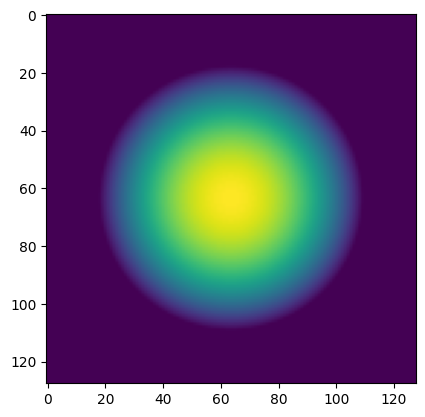

In [14]:
plt.imshow(density(solution[-1][...,0] + 1j*solution[-1][...,1]))

In [ ]:

def tf_mu_2d_from_class(N, g, trap_factor, e):
    # squared freqs:
    wx2 = trap_factor * (1.0 + e)
    wy2 = trap_factor * (1.0 - e)
    wx, wy = jnp.sqrt(wx2), jnp.sqrt(wy2)
    mu = jnp.sqrt((N * g * wx * wy) / (2.0 * jnp.pi))
    return mu, wx2, wy2

def tf_density_2d_from_class(X, Y, N, g, trap_factor, e):
    mu, wx2, wy2 = tf_mu_2d_from_class(N, g, 0.5 * trap_factor, e)
    V = 0.5 * (wx2 * X**2 + wy2 * Y**2)
    n = jnp.clip((mu - V) / g, min=0.0)
    # tiny renormalization (discretization error) to hit N exactly:
    dx = (X[1,0] - X[0,0])
    dy = (Y[0,1] - Y[0,0])
    Nin = jnp.sum(n) * dx * dy
    n = n * (N / (Nin + 1e-12))
    return n

X, Y = domain_.mesh()

tf_density = tf_density_2d_from_class(X, Y, 1.0, k, 1.0, 0.0)   

np.testing.assert_allclose(tf_density, density(solution[-1][...,0] + 1j*solution[-1][...,1]), rtol=1e-3, atol=1e-3)

In [5]:
def density(psi):
    return jnp.abs(psi)**2

In [6]:
# Get variables with dimensions
atoms = 5e5
hbar = 1.05e-34 #J*s
omega = 2*jnp.pi*10 #1/s
omega_z = jnp.sqrt(8)*omega
epsilon = 0.0
mass = 3.8175406e-26 #kg (atomic mass of sodium-23)
a0 = 5.29177210903e-11
a_s = 100*a0
N = 128

x_s = jnp.sqrt(hbar/(mass*omega))
t_s = 1/omega

# Length of the x and y axes in meters
Lx = 150e-6 #meters
Ly = 150e-6 #meters

# Get dimensionless variables
Lx_ = Lx/x_s
Ly_ = Ly/x_s

# Get k
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass*omega_z)/(2*jnp.pi*hbar))

epsilon = 0.0

t_start = 0.0
t_final = 0.1
dt = 1e-5

t_start_ = t_start/t_s
t_final_ = t_final/t_s
dt_ = dt/t_s

domain_ = Domain((N,N,), ((-Lx_/2, Lx_/2), (-Ly_/2, Ly_/2),), "dimensionless")

In [7]:
Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

In [8]:
eq = GPE2DTSControl(domain_, k, epsilon, lambda a,b,c: 0.0, trap_factor=1.0)

solver = StrangSplitting(eq.A_term, eq.domain.dx[0], eq.fft, eq.ifft, -1j)


In [12]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.B_terms(y, t))),
    solver,
    t0=t_start_,
    t1=t_final_,
    dt0=dt_,
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    stepsize_controller=diffrax.ConstantStepSize(),
    saveat=diffrax.SaveAt(ts=jnp.linspace(t_start_, t_final_, 100)),
    max_steps=1000000,
    adjoint=diffrax.ForwardMode(),
)

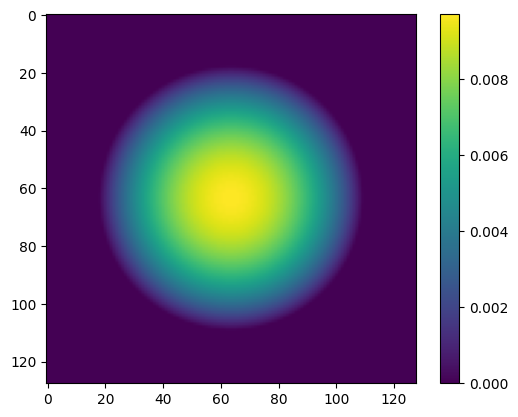

In [10]:
plt.imshow(density(solution.ys[-1][...,0] + 1j*solution.ys[-1][...,1]))
plt.colorbar()

In [38]:
def tf_mu_2d_from_class(N, g, trap_factor, e):
    # squared freqs:
    wx2 = trap_factor * (1.0 + e)
    wy2 = trap_factor * (1.0 - e)
    wx, wy = jnp.sqrt(wx2), jnp.sqrt(wy2)
    mu = jnp.sqrt((N * g * wx * wy) / (2.0 * jnp.pi))
    return mu, wx2, wy2

def tf_density_2d_from_class(X, Y, N, g, trap_factor, e):
    mu, wx2, wy2 = tf_mu_2d_from_class(N, g, 0.5 * trap_factor, e)
    V = 0.5 * (wx2 * X**2 + wy2 * Y**2)
    n = jnp.clip((mu - V) / g, a_min=0.0)
    # tiny renormalization (discretization error) to hit N exactly:
    dx = (X[1,0] - X[0,0])
    dy = (Y[0,1] - Y[0,0])
    Nin = jnp.sum(n) * dx * dy
    n = n * (N / (Nin + 1e-12))
    return n

In [39]:
X, Y = domain_.mesh()

tf_density = tf_density_2d_from_class(X, Y, 1.0, k, 1.0, 0.0)

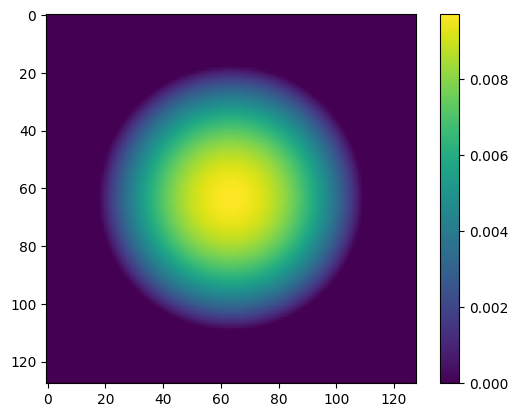

In [40]:
plt.imshow(tf_density)
plt.colorbar()

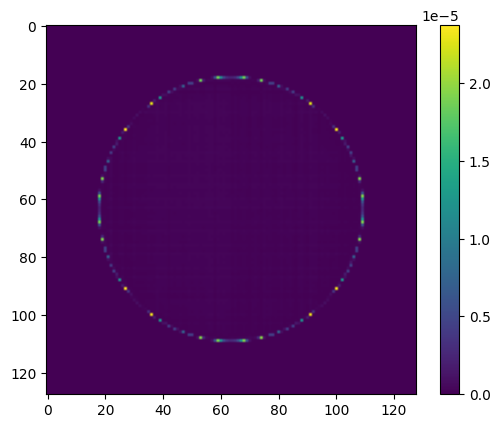

In [41]:
real_density = density(solution.ys[-1][...,0] + 1j*solution.ys[-1][...,1])

plt.imshow(jnp.abs(tf_density - real_density))
plt.colorbar()